In [3]:
# EXECUTE FIRST

# computational imports
import numpy as np
import pandas as pd
from scipy.optimize import minimize, minimize_scalar
from sklearn.linear_model import LogisticRegression
import json

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# display imports
from IPython.display import display, IFrame
from IPython.core.display import HTML

# for playing videos, customize height and width if desired
def play_video(vid_name, w=640, h=360):
    vid_path = "https://media.uwex.edu/content/ds/ds775_r19/" + vid_name + "/index.html"
    hlink = '<a href = ' + vid_path + ' target = """_blank""">Open video in new tab</a>'
    display(IFrame(vid_path, width=w, height=h))
    display(HTML(hlink))

# Lesson 05: Local Optimization

**Students find Lessons 5, 6, and 7 to be the most difficult to follow.  I'd love to improve these lessons and would really like your feedback and suggestions in Piazza.  Please don't hesitate to ask lots of questions.**

# Optimization Basics (video)

Work your way through the embedded storybook below to learn some basic ideas about optimization.  This material complements the material in the textbook.  The graphs and demos in Slides 9-11 are available in the separate file Graphs_for_Video.ipynb in the Extras folder.

In [4]:
# execute this cell for video
play_video("ds775_lesson5-optimization-basics", w = 900, h = 600)

# Quadratic Programming

You should read about quadratic programming in the textbook.  In short, the constraints are the same as they are in linear programming and the objective function can have degree 2 and interaction terms.  In Pyomo it is only a matter of changing the solver to one capable of solving quadratic programs, `ipopt`, instead of `glpk`.  Other solvers like CPLEX, a commercial solver, could also be used.  You  may need to install `ipopt` using conda on your own machine.

## Wyndor Example

We'll use Pyomo to solve the quadratic variation of the Wyndor problem illustrated in Figure 13.6 on page 554.

<img src="images/wyndor_quad.png" width="600">

This kind of profit function occurs when the price depends on demand.  We'll use a concrete model formulation for simplicity.  Note, the Pyomo package `minimize` conflicts with the `minimize` from `scipy.optimize` we're using elsewhere in this notebook, so we'll import `pyomo` a bit differently here than usual.  Alternately we could re-import `minimize` from `scipy.optimize` after we're done with Pyomo.

In [5]:
# unfold to see Pyomo solution for Wyndor Quadratic Program
import pyomo.environ as pyo

# Concrete Model
model = pyo.ConcreteModel(name="Wyndor")

products = ['drs', 'wdw']

bounds_dict = {'drs': (0, 4), 'wdw': (0, 6)}

def bounds_rule(model, product):  # using a bounds_rule is a good way to implement simple bounds
    return (bounds_dict[product])


model.x = pyo.Var(products, domain=pyo.Reals, bounds=bounds_rule)

# Objective
model.profit = pyo.Objective(expr=126.0 * model.x['drs'] -
                         9.0 * model.x['drs']**2 + 182.0 * model.x['wdw'] -
                         13.0 * model.x['wdw']**2,
                         sense=pyo.maximize)

# Constraints
model.Constraint3 = pyo.Constraint(
    expr=3.0 * model.x['drs'] + 2.0 * model.x['wdw'] <= 18)

# Solve
solver = pyo.SolverFactory('ipopt')
solver.solve(model)

# display solution
print(f"Profit = ${1000*model.profit():,.2f}")
print(f"Batches of Doors = {model.x['drs']():1.2f}")
print(f"Batches of Windows = {model.x['wdw']():1.2f}")

Profit = $857,000.00
Batches of Doors = 2.67
Batches of Windows = 5.00


# Local Search - Continuous Variables

Local search algorithms for continuous variables are generally based on approximating the objective function near the current search point, then using that approximation to compute an improved search point.  For instance if we can calculate the gradient (calculus) or approximate it, then a move along the gradient direction will increase the value of the function.  

We'll primarily use the `scipy.optimize` function `minimize` for local search on continuous functions.  You can read more about it below.  

## Minimize from scipy.optimize

In [6]:
# execute this cell to see scipy.optimize.minimize documentation
IFrame(
    "https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize",
    width=900,
    height=600)

While there are many options here, the defaults will serve well for our purposes.  The `method` specifies a variety of different numerical algorithms for local search.  We'll use `BFGS` for unbounded problems and `L-BFGS-B` for problems with bounds.  You shouldn't have to specify that choice as those are the defaults.  The BFGS methods are robust algorithms and are known as quasi-Newton methods.  What this means is that they approximate the shape of the objective function near the current point by approximating the derivatives (slopes and curvature) of the function and that shape information is used to produce an improved search point. 

One of the things to pay attention to here is how we have to write our objective functions so that they can be passed to the `minimize` function.

### A univariate function

Lets investigate the fourth degree polynomial $$p(x) = x^4 + 2 x^3 + 3 x^2 + 2 x + 1.$$  Let's graph it to get an idea of the behavior. 

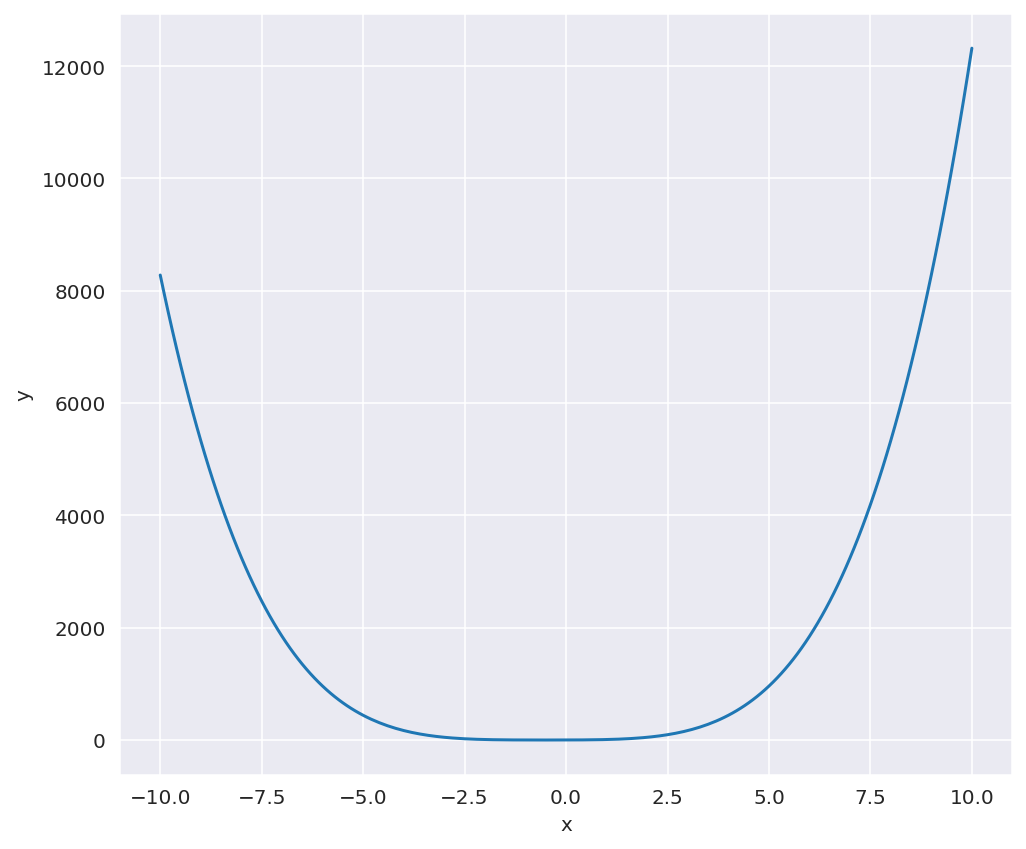

In [7]:
# plot p(x) on [-10,10]
x = np.linspace(-10,10,201)
p = lambda x:x**4 + 2*x**3 + 3*x**2 + 2*x + 1 
fig = plt.figure(figsize=(8,7)) # adjust figsize if needed
plt.plot(x,p(x));
plt.xlabel('x');
plt.ylabel('y');
# two notes here:
# 1. lambda is useful for defining one-line functions
# 2. if x is a numpy array then x**2 and so on makes sense ... it squares each element in the array
#.   numpy arrays can be useful for streamlining computations

The overall "U" shape is not surprising since for polynomials the behavior for large values of $x$ is determined by the highest degree term which is, in this case, $x^4$.  It appears that there is a minimum or minima close to the origin.  Let's zoom in a bit to see what we can:

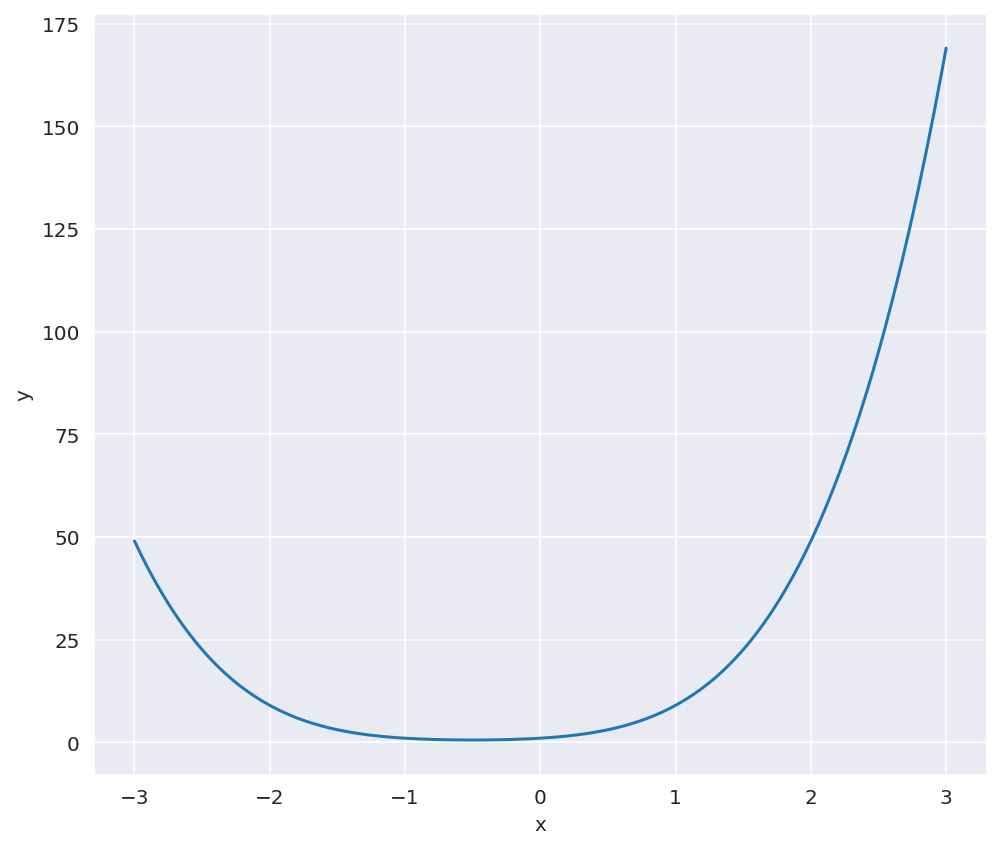

In [8]:
# plot p(x) on [-3,3]
x = np.linspace(-3,3,201)
p = lambda x:x**4 + 2*x**3 + 3*x**2 + 2*x + 1
fig = plt.figure(figsize=(8,7))
plt.plot(x,p(x));
plt.xlabel('x');
plt.ylabel('y');

There appears to be only one minimum somewhere around $x=0$ or $x=-1$.  Since the function appears to be convex, the starting point doesn't matter.  Let's search for the minimum beginning at $x_0 = -2$:

In [9]:
# execute for local search
result = minimize(p,-2)
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.5625000000001792
        x: [-5.000e-01]
      nit: 6
      jac: [-1.006e-06]
 hess_inv: [[ 3.331e-01]]
     nfev: 14
     njev: 7

In [10]:
print(f"The minimum value is {result.fun:0.4f} and occurs at x = {result.x[0]:0.4f}")

The minimum value is 0.5625 and occurs at x = -0.5000


## Minimize_scalar from scipy.optimize

For functions of a single variable we can also use the minimize scalar function as below.  In some cases you may need to use this instead of `minimize` which applies to multivariable functions.

In [11]:
result = minimize_scalar(p, bounds=(-3, 3), method='bounded')

print(f'The minimum value is {result.fun:0.4f} and occurs at x = {result.x:0.4f}')

The minimum value is 0.5625 and occurs at x = -0.5000


###  *Self Assessment:  Minimize to Maximize*

An apartment complex has 250 apartments to rent and that their profit in thousands of dollars is given by the function 
$$P(x) = -0.008 x^2 + 3.1 x - 80.$$
Find the maximum profit and how many apartments to rent to achieve the maximum profit.  Use minimize from scipy.optimize to find the maximum.  Review the video above to see how to "flip" the problem to find a maximum.

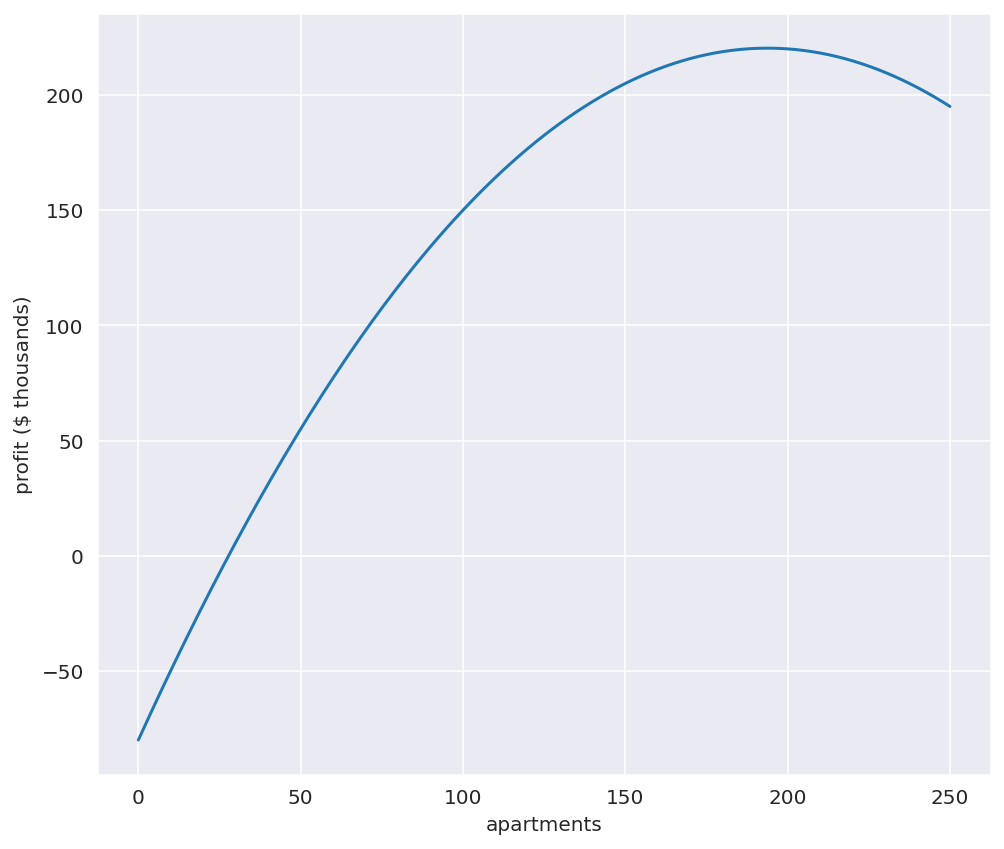

In [12]:
# graph of profit function
x = np.linspace(0,250,201) # 201 points between 0 and 250
P = lambda x:-0.008*x**2 + 3.1*x - 80 # lambda is for writing one line functions
fig = plt.figure(figsize=(8,7));
plt.plot(x,P(x));
plt.xlabel('apartments');
plt.ylabel('profit (\$ thousands)');

In [13]:
# add your code here, note you should be able to guess an initial value from the graph ...

Your answer shouldn't be an integer.  We could use discrete optimization and only optimize integer numbers of apartments, but it will usually be more computationally intensive.  Instead we're using a continuous variable to get an approximation to the discrete problem, this is called **relaxation** (we've relaxed the integer variable condition).  So what whole number of apartments should you rent?  Why? 

### *Self Assessment:  Finding Multiple Extrema*

The function $f(x) = x^5 - x^4 - 18 x^3 + 16 x^2 + 32 x - 2$ for $-4 \leq x \leq 3.6$ appears in the video "Gradient Descent and Local Minima" above.  Plot the function on the given interval.  Use the graph to guess where the local maxima and minima are.  Now use minimize from scipy.optimize to find the $x$ and $y$ coordinates of all the extrema.  You can add bounds to the minimize call like this:

```python
minimize(f, x0, bounds=[(-4,3.6)])
```
Local extrema only occur on the interior of the interval and not at the endpoints.

## Example: Simple Logistic Regression

### Video Walkthrough of this example

In [14]:
# execute this cell for video
play_video("ds775_lesson5-logistic-regression")

### Setup for Logistic Regression

Most machine learning algorithms are driven by optimization.  Usually we want to minimize a loss function which measures the difference between the model predictions and the observed data.  Neural network training uses a version of the gradient descent algorithm to optimize the weights in the network.  Here we'll show how to fit a logistic regression model by maximizing a function.

In simple logistic regression we try to predict the value of the label $y$, which can be 0 or 1, for each value of a continuous predictor variable $x$.  In particular, the conditional probability that $y=1$ given the current value of $x$ is modeled by a sigmoid function ("s" curve) $$p(x) = \frac{1}{1 + e^{-(b_0 + b_1 x)}}.$$

For example, the more hours a student studies to prepare for an exam, the higher the probability that they will pass the test.  Shown below is some data.  For each student we have the number of hours they studied and whether or not they passed the exam (1 for passed, 0 for failed).  This example data comes from the <a href="https://en.wikipedia.org/wiki/Logistic_regression">Wikipedia article on Logistic Regresssion</a>.

### An example

In [15]:
# data from 
x_hours = np.array([
    0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 1.75, 2.0, 2.25, 2.50, 2.75, 3.00, 3.25,
    3.5, 4.0, 4.25, 4.5, 4.75, 5.0, 5.5
])
y_passed = np.array([0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1])

Below is a graph of the data along with the graph of the fitted sigmoid function that models the probality of $y=1$ at each $x$.  Don't worry, we'll see where the fitted curve comes from in a bit.

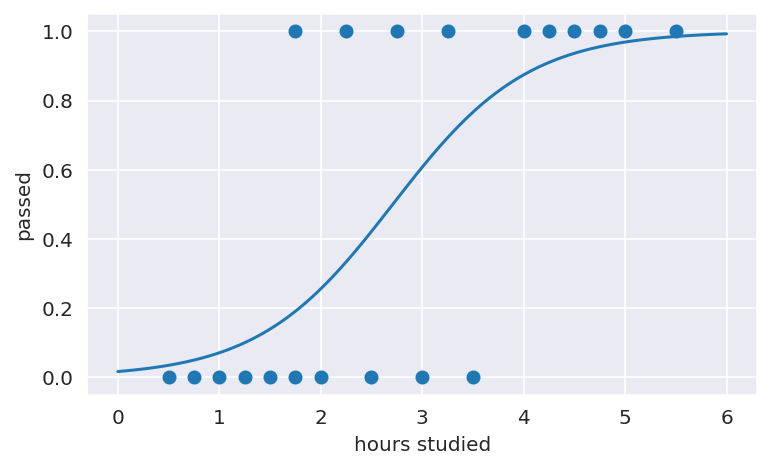

In [16]:
# graph of data and sigmoid
b0 = -4.07771657
b1 = 1.5046468
hours_studied = np.linspace(0,6,101)
def sigmoid(x,intercept,slope):
    return( 1.0 / (1.0 + np.exp( -(intercept + slope * x) ) ) )
prob_passed = sigmoid(hours_studied, b0, b1)

fig = plt.figure();
fig.set_size_inches(6,3.5); # change size if needed on your display
ax = fig.add_subplot(111);
ax.scatter(x_hours, y_passed);
ax.plot(hours_studied, prob_passed);
ax.set_xlabel('hours studied');
ax.set_ylabel('passed');

We can use the model to make predictions:

In [17]:
print(f"A student who studies 4 hours has approximately {100 * sigmoid(4, b0, b1):3.1f}% chance of passing.")

A student who studies 4 hours has approximately 87.4% chance of passing.


*Note:  It isn't important to understand the details of logistic regression for this class, but the text in this cell gives a bit of background.*

Where do those values for the slope and intercept come from?  To obtain those we find the values of $b_0$ and $b_1$ that maximize the likelihood function:
$$ L(b_0,b_1) = \prod_{i=1}^{n} p(x_i)^{y_i} (1-p(x_i))^{(1-y_i)}$$
where $(x_i,y_i)$ are the data pairs for each student and $p(x) = \displaystyle \frac{1}{1 + e^{-(b_0 + b_1 x)}}$ is the sigmoid function.  By maximizing the likelihood function we are maximizing the probability that this model produced the observed data.  Note that the $\prod$ symbol means to take the product of the values, like $\sum$ means to take the sum.

In practice, maximizing a product can lead to numerical difficulties, so we instead maximize the log-likelihood function found by taking the logarithm of $L(b_0,b_1)$ to get:
$$LL(b_0, b_1) = \sum_{i = 1}^{n} \left[ y_i \log( p(x_i) ) + (1-y_i) \log(1-p(x_i)) \right].$$

Now we need to find $b_0$ and $b_1$ to maximize this.  The log-likelihood function turns out to be concave so that ascending from any starting point will lead to the global maximum.  

Because we will use the `minimize` function from `scipy.optimize` to find the maximum log-likelihood we'll minimize the negative log-likelihood:

### Find the model with `minimize`

In [18]:
def neg_log_loss( coef, *args):
    b0 = coef[0]
    b1 = coef[1]
    x = args[0]
    y = args[1]
    p = 1.0/(1.0 + np.exp(-(b0 + b1*x)))
    ll = sum( y*np.log(p)+(1-y)*np.log(1-p) )
    return(-ll) # here's the minus sign!

Take a minute to see how this function is structured and perhaps glance at the documentation again.  `coef` is a one-dimensional array with shape (n,) that contains all $n$ optimization variables.  In this case there are two which we assign to $b_0$ and $b_1$.  `*args` is a pointer to tuple `args` that contains any additional parameters that should be passed to the function.  In the case `minimize` will be passing the tuple $(x,y)$ that contains the training data.  We'll pass `args = (x_hours, y_passed)`.

In [19]:
result = minimize(neg_log_loss,[0,0],args=(x_hours,y_passed))
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 8.029878464344716
        x: [-4.078e+00  1.505e+00]
      nit: 12
      jac: [ 2.384e-07  5.960e-07]
 hess_inv: [[ 3.059e+00 -1.028e+00]
            [-1.028e+00  3.946e-01]]
     nfev: 42
     njev: 14

In [20]:
b0 = result.x[0]
b1 = result.x[1]
print(f"The maximum likelihood estimate for p(x) has intercept b0 = {b0:2.3f} and slope b1 = {b1:2.3f}")

The maximum likelihood estimate for p(x) has intercept b0 = -4.078 and slope b1 = 1.505


Note:  the approach outlined here for logisitic regression is very similar to the actual algorithms used by most software for computing logistic regression models. Many machine learning predictive models are trained by optimization.  To verify our results we check our results against those from Sci-kit Learn.  By default sklearn uses an L2 regularization term to avoid overfitting (more about this in DS740).  The amount of regularization is proportional to $1/C$ so we just use a huge $C$ to mimic no regularization.

In [21]:
model = LogisticRegression(C=1.0e10,fit_intercept = True)
model.fit(x_hours.reshape(-1,1), y_passed)
b0 = model.intercept_[0]
b1 = model.coef_[0][0]
print(f"The maximum likelihood estimate for p(x) has intercept b0 = {b0:2.3f} and slope b1 = {b1:2.3f}")

The maximum likelihood estimate for p(x) has intercept b0 = -4.078 and slope b1 = 1.505


## Example:  The Rastrigin Function

The Rastrigin function is a common test case for optimization algorithms because it has many local minima.  The definition of the function is 
$$f(\mathbf{x})=10 n+\sum_{i=1}^{n}\left[x_{i}^{2}-A \cos \left(2 \pi x_{i}\right)\right]$$

$$f(\mathbf{x})=\sum_{i=1}^{n}\left[x_{i}^{2} + 10-A \cos \left(2 \pi x_{i}\right)\right]$$


Where $n$ is the dimensionality of input vector $\mathbf{x}$.  For instance if $n=2$ then $\mathbf{x} = (x_1, x_2)$.  The domain is restricted so that each $x_i \in [-5.12, 5.12].$ .   Here is a graph of the the Rastrigin function with dimension $n=1.$

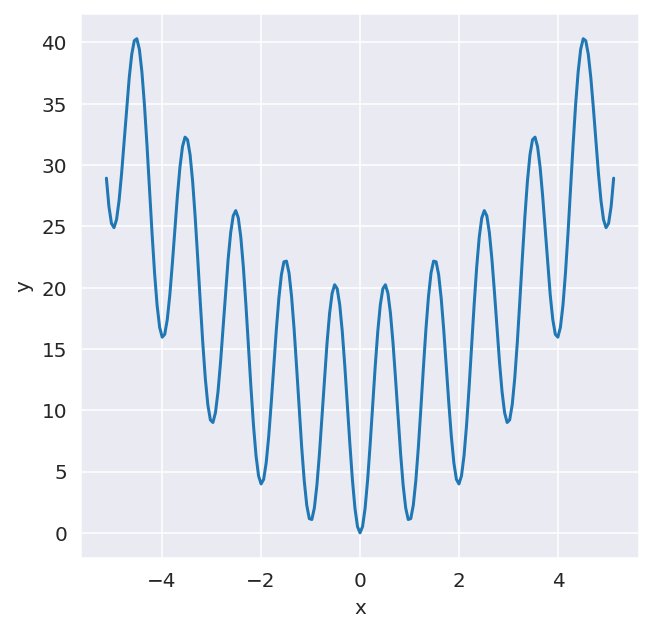

In [22]:
# open to reveal graph code
def rastrigin_1D(x):
    return (x**2 + 10 - 10 * np.cos(2 * np.pi * x))

x = np.linspace(-5.12,5.12,201)
y = rastrigin_1D(x)

fig = plt.figure(figsize=(5,5)) # adjust figsize as needed for your display
plt.plot(x,y)
plt.xlabel('x');
plt.ylabel('y');

In [23]:
# Graph of Rastrigin with dimension n = 2
%run scripts/rastrigin_2d.py

<Figure size 864x504 with 0 Axes>

The Rastrigin function isn't important as a real-life example, but it does serve as a good test problem with oodles of local minima and we know that global minimum occurs at the origin.  This is similar to what can happen in training in neural networks and other complex models except that we don't know where the global optimum is.

### Multistart for finding Global Optima

A simple approach for trying to find the global minimum of a multi-modal function is called a **restart** or **multistart strategy** in which local searches are started at randomly generated initial points and the most optimal result of all the local searches is recorded.

Here is pseudo-code for a multistart code:
```
for num_searches:
 choose random initial state
 do local search
 if new optimum
     remember it
endfor
```


In [24]:
import numpy as np
def rastrigin(x):
    # pass a single vector of length n to evaluate Rastrigin
    # the length of the vector = number of input variables = dimension
    return sum(x**2 + 10 - 10 * np.cos(2 * np.pi * x))

In [25]:
from scipy.optimize import minimize
import numpy as np
def rastrigin(x):
    # pass a single vector of length n to evaluate Rastrigin
    # the length of the vector = number of input variables = dimension
    return sum(x**2 + 10 - 10 * np.cos(2 * np.pi * x))



dim = 10 # this determines the number of inputs to the Rastrigin function, there are 10 inputs or variables with dim=10
num_local_searches = 1000
best_value = 1.e10
bounds = [(-5.12,5.12) for i in range(dim)] # make a list of tuples to give bounds for each of the dim = 10 variables
# bounds = [(-5.12,5.12)]*dim  # this is a nice trick for lists that does the same thing

for i in range(num_local_searches):
    x_initial = np.random.uniform(-5.12, 5.12, dim)
    result = minimize(rastrigin,x_initial,bounds=bounds)
    if result.fun < best_value:
        best_value = result.fun
        best_x = result.x
        print(f"New best value is {best_value:1.3f}")

print(f"\nThe smallest value found is {best_value:4.3f}")
print(f"The location where the smallest values occurs is:")
for i in range(dim):
    print(f"    x{i} = {best_x[i]:1.3f}")

New best value is 88.551
New best value is 80.591
New best value is 71.637
New best value is 52.733
New best value is 37.808
New best value is 36.813


New best value is 35.818
New best value is 22.884


New best value is 16.914


New best value is 16.914


New best value is 13.929



The smallest value found is 13.929
The location where the smallest values occurs is:
    x0 = 0.995
    x1 = -0.995
    x2 = 0.995
    x3 = -1.990
    x4 = -0.000
    x5 = 0.995
    x6 = 1.990
    x7 = 0.000
    x8 = 0.995
    x9 = 0.995


**Note: dimensions or `dim` is the number of input variables to the objective function.**

### *Self-Assessment: Rastrigin with dim = 3, 4*

How many iterations does it take to reliably find the global minimum with dim = 3?  With dim = 4?  Use the multi-start strategy.  There is not an exact answer to this question, just experiment with `num_local_searches` ... what is the smallest number of searches so that you find the global minimum value of 0 almost every time?

### *Self-Assessment:  Rastrigin with dim = 10*

Do 1000 local search with Rastrigin with dim = 10.  What is the smallest value you find?  How long do you think it would take to find the minimum from randomly chosen initial points like this?  Again, there is no right answer, just experiment to get an idea how increasing the number of variables can make it **much** more difficult to find the global minimum.

## The curse of dimensionality

If we are maximizing a function of one variable, $f(x)$, we might choose to use 10 starting points.  For a function of two variables, $g(x,y)$ to get the same search power we would choose 10 points in the $x$ direction and 10 points in the $y$ direction to make a grid of $10^2 = 100$ starting points in the $xy$-plane.  For three variables we need $10^3 = 1000$ points in $xyz$-space.  For a function of $n$ variables we would need $10^n$ starting points. ($n$ is the same as `dim` in the code above.)

*The volume of the search space grows exponentially with the number of variables or dimensionality of the problem.*

This is called the curse of dimensionality.  For high dimensional functions like those that occur in training neural networks and other applications with many local minima it can be very difficult to find the global minima because the volume of the search space grows exponentially with the number of variables.

For the Rastrigin function to find the global minimum you need an initial starting point in the interval (-0.5,0.5) in each dimension.  The search interval is [-5.12,5.12] in each dimension.  Thus the probability that a single uniformly sampled point in [-5.12,5.12] is $\frac{1}{10.24} \approx 0.0977$ (the ratio of the lengths of the two intervals).  The probability of finding the global minimum using local search from a uniformly sampled point in $n$ dimensions is $$\left( \frac{1}{10.24} \right)^n.$$  That means we'd have to, on average, start $10.24^n$ local searches from uniformly sampled points to find the global minimum once.

### *Self-Assessment:  How many searches?*

For the Rastrigin function write a while loop that runs until the global minimum value is found ($|\mbox{best_val}|<0.01$) and track the number of iterations. Use a for loop to repeat this three times until your code is debugged.  After your code is working, repeat the process 100 times and report the average number of searches until the global minimum is found when $n=1,2,3$.  Are these numbers in approximate agreement with with the estimated numbers $10.28^n$ (they very likely won't be all that close, but how is the overall trend)?

### *Self Assessment: How many searches when dim = 10?*

Approximately now many local searches are required to find the global minimum one time when dim = 10?  Is it surprising that you (very likely) didn't find it with 1000 local searches?  Explain

# Local Search - Discrete Variables

Optimization with discrete variables tends to be more complicated than with continuous variables.  In the continuous case we can take advantage of calculus or numerical methods to compute gradient search directions that allow us to move to nearby points that are closer to optimal.  However with discrete random variables there is no generic way to compute better nearby points.  Often the best we can do is find nearby points, which is usually problem specific, and try them to see if they produce closer to optimal results.

We'll look carefully at the traveling salesman problem (TSP).  In addition to the information about the TSP in the textbook, there is copious information available on the internet.

## The Basics of Local Search

Here is pseudo-code for a simple local search.  Many variations are possible, but they often look like this:
```
 set starting state 
 while local_condition 
     select a move 
     if acceptable 
         do the move 
         if new optimum 
             remember it 
 endwhile 
 ```

Notes:

* Often the starting state is one selected at random.  State refers to the "state" or values of the variables.

* The local condition is a stopping condition.  It could be something like stopping after a fixed number of iterations or stopping after making no or insignificant process for a while.

* Selecting a move is where things get problem specific.  Often the move involves a random change to the variables.

* If acceptable means that we are checking to see that the state is feasible, that is, does it satisfy the constraints?

## Local Search for TSP

Let's see what this looks like for the TSP.  We'll use the subtour reversal algorithm, described in the textbook, to generate moves.  Here's what the local search looks like for the TSP:

```
 choose a random tour  
 while shorter tours have been found in last max_tries
     propose new tour with one random segment reversed and compute new distance
     if acceptable (it will always be a valid tour) 
         if new shortest tour 
             remember it 
         else
             reject new tour
 endwhile 
 ```

## Video for TSP Local Search Code

In [26]:
# execute this cell for video
play_video("ds775_lesson5-logistic-traveling-salesman-problem")

## TSP Local Search Code

We'll be minimizing the total length of a tour that visits all 48 state capitals in the continental United States and ends back in the same city in which it begins.  The latitudes and longitudes of the cities were projected onto a rectangular coordinate system with $x$ and $y$ coordinates representing positions in meters which we convert to kilometers.  We have stored the $x$ and $y$ coordinates and a distance matrix with distances between all of the cities in the json file `Caps48.json`.  First we load the data and define a function visualize tours of the 48 capitals.  We plot the best possible tour just to show how the plotting routine works.  The coordinates in the json file are in meters.

**Here is the optimal tour.**

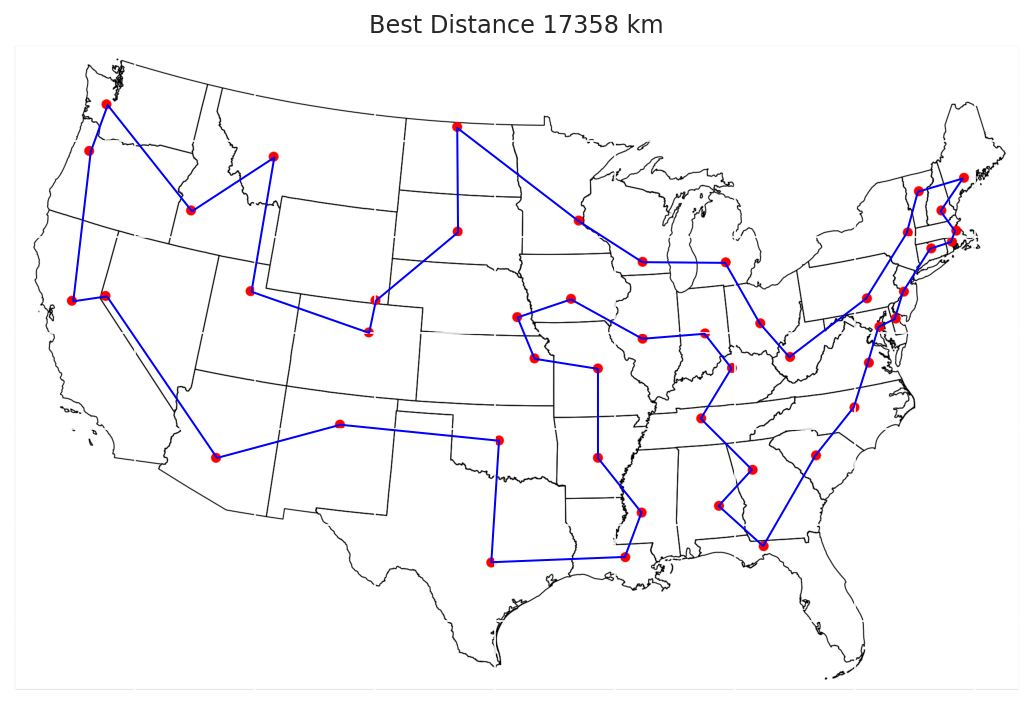

In [27]:
with open("data/Caps48.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
optimal_tour = tsp["OptTour"]
opt_dist = tsp["OptDistance"]/1000 # converted to kilometers
xy = np.array(tsp["Coordinates"])

def plot_tour(best_tour, xy_meters, best_dist, height, width):

    meters_to_pxl = 0.0004374627441064968
    intercept_x = 2.464
    intercept_y = 1342.546
    xy_pixels = np.zeros(xy_meters.shape)
    xy_pixels[:,0] = meters_to_pxl * xy_meters[:,0] + intercept_x
    xy_pixels[:,1] = -meters_to_pxl * xy_meters[:,1] + intercept_y

    fig, ax = plt.subplots(1, 1, figsize=(height, width))
    im = plt.imread('images/caps48.png')
    implot = ax.imshow(im)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

    loop_tour = np.append(best_tour, best_tour[0])
    ax.plot(xy_pixels[loop_tour, 0],
            xy_pixels[loop_tour, 1],
            c='b',
            linewidth=1,
            linestyle='-')
    plt.title(f"Best Distance {best_dist:.0f} km")

plot_tour(optimal_tour, xy, opt_dist, 9, 6) # change the height and width in the last two arguments as needed

Here we define both the local "move" function which reverses a randomly selected tour segment to generate a new tour and the objective function which computes the length of the tour in kilometers.  The local search continues until `max_no_improve` iterations have occured in which no shorter tour was found.

In [32]:
# NOTE: we refactored and improved the code a bit
# after we recorded the video.  It still works the same.
# The version of the code in the video is at the end of the notebook.


# define move, objective, and local search functions

def sub_tour_reversal(tour):
    # reverse a random tour segment
    num_cities = len(tour)
    i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
    return np.concatenate((tour[0:i], tour[j:-num_cities + i - 1:-1],
                              tour[j + 1:num_cities]))

def tour_distance(tour, dist_mat):
    distance = dist_mat[tour[-1]][tour[0]]
    for gene1, gene2 in zip(tour[0:-1], tour[1:]):
        distance += dist_mat[gene1][gene2]
    return distance/1000 # convert to kilometers

def random_reversal_search(dist_mat, max_no_improve):
    num_cities = len(dist_mat)
    # starts from a random tour
    current_tour = np.random.permutation(np.arange(num_cities)) # x0 CHANGE
    current_dist = tour_distance(current_tour, dist_mat) # y = f(x0) CHANGE

    # stop search if no better tour is found within max_no_improve iterations, can increase to eliminate crossovers
    num_moves_no_improve = 0
    iterations = 0
    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        iterations += 1  # just for tracking
        new_tour = sub_tour_reversal(current_tour) # make a move, create x_new from x_curr CHANGE
        new_dist = tour_distance(new_tour, dist_mat) # y_new = f(x_new) # CHANGE
        if new_dist < current_dist:
            num_moves_no_improve = 0
            current_tour = new_tour # accept the move if it's an improvement
            current_dist = new_dist
    return current_tour, current_dist, iterations

**Execute cell below to do the local search.  Repeat a few times to see how each local search results in a different tour corresponding to a different local minimum.**

The minimum distance found is 19539 after 2363 iterations


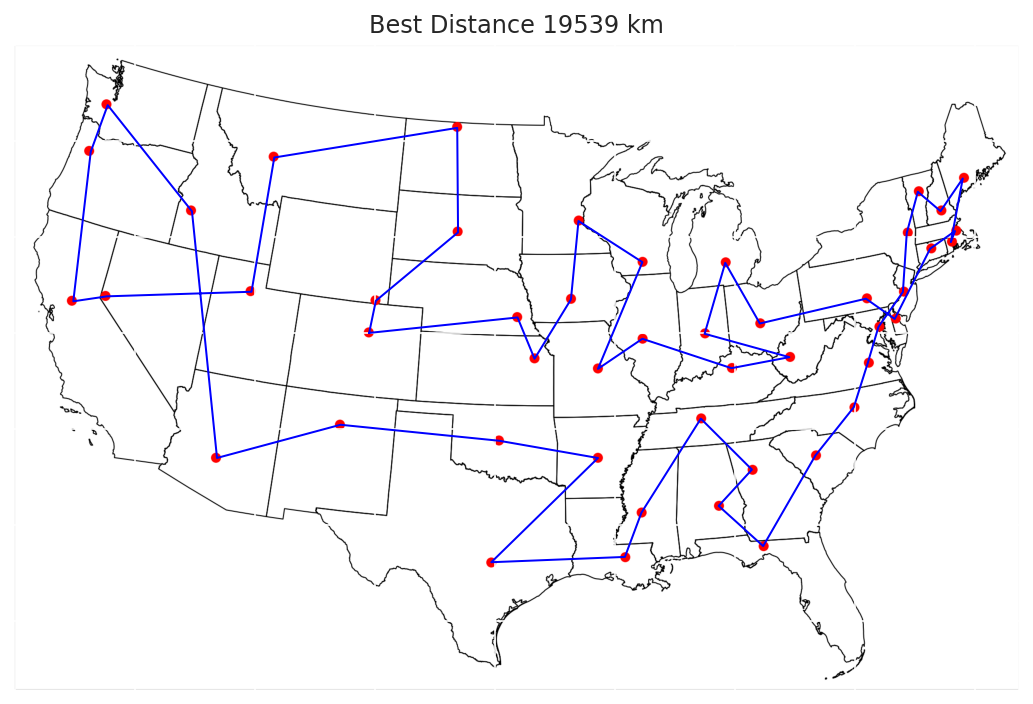

In [33]:
best_tour, best_dist, iterations = random_reversal_search(distance_matrix, 200)

print(f"The minimum distance found is {best_dist:.0f} after {iterations:d} iterations")

plot_tour(best_tour, xy, best_dist, 9, 6)

## Another local search algorithm for TSP

We'll have a look at an algorithm called "2-opt" that was proposed by Croes in 1958.  We won't focus on it much since the idea doesn't really extend to other problems.  The main idea  is to reverse segments that intersect themselves to remove the crossover.  We loop repeatedly over all the possible reversals until there are no more crossovers.  Here is some Python to do 2-opt:

The minimum distance found is 18374 km after 4512 iterations


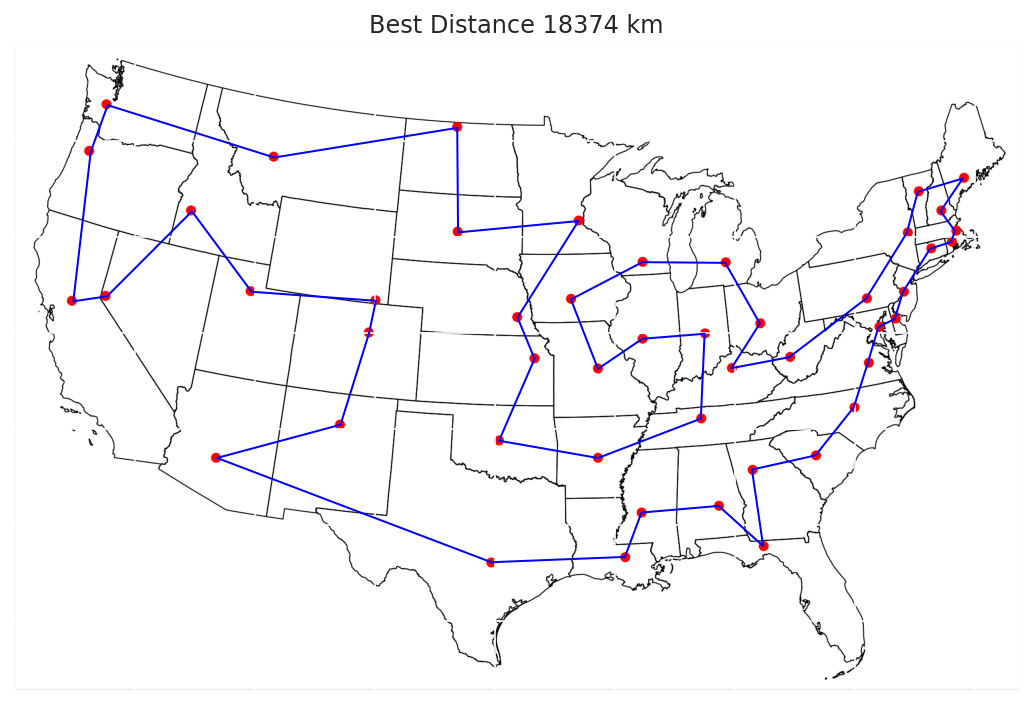

In [34]:
def sub_tour_reversal_ij(tour, i, j):
    # reverse the segment from city i to city j
    n = len(tour)
    return (np.concatenate((tour[0:i], tour[j:-n + i - 1:-1], tour[j + 1:n])))

# 2-opt local search for TSP
def two_opt(dist_mat):
    num_cities = len(dist_mat)
    current_tour = np.random.permutation(np.arange(num_cities))
    current_dist = tour_distance(current_tour, dist_mat)
    best_tour = current_tour
    best_dist = current_dist

    improvement = True
    iterations = 0
    while improvement:
        improvement = False
        for i in range(num_cities - 1):
            for j in range(i + 1, num_cities):
                iterations += 1
                new_tour = sub_tour_reversal_ij(best_tour, i, j)
                new_dist = tour_distance(new_tour, dist_mat)
                if new_dist < best_dist:
                    best_tour = new_tour
                    best_dist = new_dist
                    improvement = True
    return best_tour, best_dist, iterations

best_tour, best_dist, iterations = two_opt(distance_matrix)

print(f"The minimum distance found is {best_dist:.0f} km after {iterations:d} iterations")

plot_tour(best_tour, xy, best_dist, 9, 6)

2-opt is can use fewer iterations to find a reasonable tour (local minimum) than does our local search with random segment reversals.  2-opt guarantees that there are no "crossovers" in the final tour.  In the next lesson, we'll try using 2-opt to find starting points for a global search algorithm.

## Value Balancing Example

This is an example of a fairly simple discrete optimization problem. You have a collection of Y item values. Break the group of items into N sub-groups, having equal value. For instance, given a group of 4 items with the following values:

* Item A = 5
* Item B = 10
* Item C = 23
* Item D = 8

we would want to put items A, B, and D in one group and item C in another group. If the values represent times, then the total time used by each group is 23. Think of this as a load-balancing task where the goal is to balance the times used by the processors.

We'll make this easier by using numpy arrays to store our values, and using another numpy array to do assignment into groups.
See the code in the next cell for one way we would determine the difference between the value of each of our groups, given a numpy array. (Note that there are simpler ways to do this if we know that we're always going to break this into 2 groups, but this is a quick way to do it given an arbitrary number of groups.)

In [35]:
import numpy as np
import pandas as pd

num_groups = 2

#first we'll set up our values and our groups
values = np.array([5,10,23,8])

#let's start by just assigning every other item to a different group - these are the group labels
groups = np.array([0,1,0,1])

#Numpy arrays can easily be tossed into dataframes for display
# not needed for solution
df = pd.DataFrame({'values': values, 'groups': groups})
print('Our data at the start')
display(df)

#we can loop over the data and total the sum for each group
sums = np.array([ sum( values[ groups == i] ) for i in range(num_groups) ])

# display the sums in a dataframe (not necessary for solution)
value_sums_df = pd.DataFrame({'Group': np.arange(0,num_groups), 'Sum':sums})
display(value_sums_df)

#compute the range of the value sums (will be >= 0)
maxdif = max(sums) - min(sums)

print(f'The maximum difference between groups is {maxdif}')

Our data at the start


values  groups
0       5       0
1      10       1
2      23       0
3       8       1

Group  Sum
0      0   28
1      1   18

The maximum difference between groups is 10


We can condense the above code into a single function that returns the fitness (the number we'll be minimizing) of our current grouping.


In [36]:
# the objective function

def group_fitness(groups,num_groups,values):
    # groups must be a numpy array for this to work
    sums = np.array([ sum( values[ groups == i] ) for i in range(num_groups) ])
    return max(sums)-min(sums)

print(f'The current group fitness is {group_fitness(np.asarray([0,1,0,1]),2,values)}')

The current group fitness is 10


To be clear, the decision variables in this problem are the vector group assignments which were '[0,1,0,1]' in the example above (items A and C are assigned to group 0, items B and D are assigned to group 1).  Our job is to intelligently vary those group assignments until we balance, as best we can, the total values of the groups

Next, we need some mechanism to change the groups. In the next cell, we have a function that does just that. It does the following:
* determines what the possible choices are (each of the unique groups)
* makes a copy of the groups
* selects an item to change, by drawing a random integer between 0 and the length of the array of groups
* pulls a random draw from our choices of groups
* checks to make sure that our new choice isn't the same as our old choice
    * If it is the same, it iteratively loops until it's not the same (we want to ensure that we're actually making a change on each attempt
* returns the new group

Run the following cell multiple times with debug set to True until you understand what's happening.

In [37]:
# the move function

def change_group(groups, num_groups, debug=False):
    #get the unique groups
    choices = np.arange(0,num_groups)
    #get a copy of the groups
    new_groups = groups.copy()
    #select item to change
    switch = np.random.randint(0, groups.shape[0])
    #select new group value
    new_group = np.random.choice(choices)
    while groups[switch] == new_group:
        new_group = np.random.choice(choices)
    new_groups[switch] = new_group
    if debug:
        print(f'The item at {switch} should change to {new_group}')
        print(f'The initial groups are: {groups} and the changed groups are {new_groups}')
    return new_groups

groups = np.array([0,1,0,1])

print(f'The new group is {change_group(groups, num_groups, debug=True)}')

The item at 1 should change to 0
The initial groups are: [0 1 0 1] and the changed groups are [0 0 0 1]
The new group is [0 0 0 1]


### *Self Assessment: Value Balancing Local Search*

Your job is to write a function that accepts the values, the number of groups, and the maximum moves with no improvement and attempts to minimize the difference in value between each group. You may also include a debug parameter to help you in writing the code. (Feel free to add your own print statements using the debug parameter.)

See if your code can find the correct answer to our 4-item/2 group problem first, using just 10 for the number of loops without improvement. Even if you don't use the debug flag, use plenty of print statements to help you follow the action at first.

When you have that working, using the following code to generate a larger list of item values. Break it into 4 groups. You will need to up the maximum moves without improvement for the second problem, but we were able to do it with the maximum moves with no improvement set to 200.

In [38]:
# generate data for 1000 item / 4 group problem

# the weird construction here guarantees that 4 groups can be perfectly balanced so the global min is zero, the algorithm probably won't find exactly the global min though
import numpy as np

np.random.seed(123)

tot_num_items = 1000 # should be divisible by 4
num_items = int(tot_num_items / 4)
num_groups = 4

values = np.random.randint(10,100,size=num_items)
values = np.hstack([values,values,values,values]) # values of all items
groups = np.random.randint(num_groups,size=tot_num_items) # initial assignment of items to groups

np.random.seed()


## An Object-Oriented Approach to Local Search

In the next lesson we're going to use a Python package called `simanneal` that uses an object-oriented programming (OOP) approach to optimizing a function with a simulated annealing algorithm.  We'll introduce an object-oriented approach to local search in this lesson to help you understand how it works.

### OOP Review

Here is a 23-minute video to review some ideas from object-oriented programming in Python.  This video isn't comprehensive, but it should serve to refresh your memory a little.

<iframe width="560" height="315" src="https://www.youtube.com/embed/ka6-_RfR9XA" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Solving the Traveling Salesman Problem with OOP

We'll solve the Traveling Salesman Problem (TSP) from above using this approach.  To begin with we import the `LocalSearcher` class from the `localsearch` package contained in the same directory as this presentation.

```python
from locsearch import LocalSearcher
```

Since the framework for local search is independent of the particular task, we'll take advantage of Abstraction to hide the details of the local search algorithm.  Here is the local search method as it's implemented in the `LocalSearcher` class:

```python
def localsearch(self):
    """Minimizes the objective function value by local search.

    Parameters
    state : an initial arrangement of the system

    Returns
    (state, objective): the best state and objective function value found.
    """
    self.iterations = 0
    num_moves_no_improve = 0

    # set initial state and compute initial objective value
    self.best_x = self.copy_state(self.state)
    self.best_f = self.objective()
    self.update() # output to screen

    # main local search loop
    while num_moves_no_improve < self.max_no_improve:
        num_moves_no_improve += 1
        self.iterations += 1
        curr_state = self.copy_state(self.state)
        self.move() # stores new state with move in self.state
        new_f = self.objective()
        if new_f < self.best_f:
            num_moves_no_improve = 0
            self.best_x = self.copy_state(self.state)
            self.best_f = new_f
        else: # if move not improvement reset state to curr_state
            self.state = self.copy_state(curr_state)
        if( self.iterations % self.update_iter == 0): # output every update_iter iterations
            self.update() # print output

    # output one last time for final iteration
    self.update()

    # Return best state and energy
    return self.best_x, self.best_f
```

Notice that this method works on the object itself.  We don't pass in an initial state or other data.  Instead, we'll make a subclass of `LocalSearcher` that inherits the localsearch method. Then we'll set the initial state and other problem data when we create an instance of our subclass.

We'll also have to define two methods in our subclass:  `objective()` and `move()`.  The first contains the objective function to be minimized and the second contains the details for creating a local change, or move, to the current state (values of the decision variables that are stored in self.state).  If our objective function requires more than just the decision variables, we'll also have to add that to the subclass by defining an `__init__` constructor in the subclass.

To solve a TSP problem we'll use the `sub_tour_reversal` and `tour_distance()` functions from above to define our `move()` and `objective()` methods respectively:



In [39]:
def sub_tour_reversal(tour):
    # reverse a random tour segment
    num_cities = len(tour)
    i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
    return np.concatenate((tour[0:i], tour[j:-num_cities + i - 1:-1],
                              tour[j + 1:num_cities]))

def tour_distance(tour, dist_mat):
    distance = dist_mat[tour[-1]][tour[0]]
    for gene1, gene2 in zip(tour[0:-1], tour[1:]):
        distance += dist_mat[gene1][gene2]
    return distance/1000 # convert to kilometers

Now we need to create an object of the `LocalSearcher` class.  We'll do that in the cell below and then explain each part:

In [40]:
from locsearch import LocalSearcher

class TravelingSalesmanProblem(LocalSearcher):
    """
    Test local search with a traveling salesman problem
    """
    
    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        # important - super() calls the constructor of the parent class
        super(TravelingSalesmanProblem, self).__init__(state) # sets self.state

    def move(self):
        self.state = sub_tour_reversal(self.state)

    def objective(self):
        return tour_distance(self.state,self.distance_matrix)

First, we import the `LocalSearcher` class from the `locsearch` package.
```python
from locsearch import LocalSearcher
```

If you want to see all the details have a look at `localsearch/ls.py` in the same directory as this notebook.

Now we define a new class called `TravelingSalesmanProblem` that inherits from the `LocalSearcher` class:

```python
class TravelingSalesmanProblem(LocalSearcher):
    """
    Test local search with a traveling salesman problem
    """
```

For the TSP we'll need to provide the distance matrix as an extra input to the objective function.  We need to tell the `__init__` constructor that we're going to input an extra argument in addition to the initial state. The `super()` command tells Python to use the `__init__` constructor that is inherited from the parent class `LocalSearcher` to set self.state:
```python
# pass extra data (the distance matrix) into the constructor
def __init__(self, state, distance_matrix):
    self.distance_matrix = distance_matrix
    super(TravelingSalesmanProblem, self).__init__(state)
```
It's important to include the `super()` command and also to add the additional arguments after `self` and `state` in the arguments to `__init__`.  If you don't need to pass arguments other than `state` to your objective function then you can leave out the whole `__init__` constructor from your subclass definition.

Now we have to define the `move()` method.  The parent class has a `move()` method that is inherited by our `TravelingSalesmanProblem` class, but it doesn't actually do anything (this is Polymorphism in action).  To create our `move()` method we simply call our `sub_tour_reversal()` to create a new tour.
```python
def move(self):
    self.state = sub_tour_reversal(self.state)
```

You could also include all the code to compute the new tour into the `move()` method, but it's easier to call the `sub_tour_reversal()` function we defined already.

Finally, we have to define our objective function.  There is an `objective()` method inherited from the parent `LocalSearcher` class, but it doesn't do anything.  To build our own we just call the already defined `tour_distance()` function.  Notice that `tour_distance()` needs two arguments:  a tour which is stored in `self.state` and the distance matrix which is stored in `self.distance_matrix` because we told our `__init__` constructor to add that to our object.

```python
def objective(self):
    return tour_distance(self.state,self.distance_matrix)
```

So far we haven't actually created an object of the `TravelingSalesmanProblem` class, instead we've just defined the class.

**NOTE:  it's important that you store the decision variables in self.state and not somewhere else.  The search method expects the variables to be in self.state.**

The next steps are to read the problem data, create an initial state, create the TSP object, and do the optimization.  These steps are shown in the code in the next cell.

In [41]:
from locsearch import LocalSearcher

# read problem data
with open("data/Caps48.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]

# create initial state
num_cities = len(distance_matrix)
init_tour = np.random.permutation(np.arange(num_cities))

# create a tsp object of the TravelingSalesmanProblem class
tsp = TravelingSalesmanProblem(init_tour, distance_matrix)

# call the local search method in our object to do the search
best_tour, best_dist = tsp.localsearch()


 Obj Fun Val | Iterations
    44690.49 | 100
    38307.17 | 200
    32135.08 | 300
    30786.04 | 400
    29090.21 | 500
    27256.20 | 600
    25419.57 | 700
    24526.70 | 800
    24253.55 | 900
    23949.49 | 1000
    23525.50 | 1100
    22957.76 | 1200
    21494.54 | 1300
    20897.78 | 1400
    20858.42 | 1500
    20614.28 | 1600
    20614.28 | 1700
    20466.80 | 1800
    20466.80 | 1900
    19892.36 | 2000
    19892.36 | 2100
    19892.36 | 2200
    19892.36 | 2300
    19745.97 | 2400
    19187.48 | 2500
    19187.32 | 2600
    19187.32 | 2700
    18985.96 | 2800
    18985.96 | 2900
    18985.96 | 3000
    18985.96 | 3100
    18985.96 | 3200
    18985.96 | 3300
    18985.96 | 3400
    18985.96 | 3500
    18985.96 | 3600
    18985.96 | 3700
    18985.96 | 3736


That sure seemed like a lot of work, but notice that all the messy bookkeeping details of the local search are inherited from the `LocalSearcher` class so that we don't have to pay attention to the details.  Instead, we can focus on just the essence of the problem - the objective function and a procedure for generating a local search step or move.  You can change default values of search and settings variables too.  For example, suppose we wanted to stop the search after making no progress for 300 iterations and wanted to print output every 200 iterations:

In [42]:
# read problem data
with open("data/Caps48.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]

# create initial state
num_cities = len(distance_matrix)
init_tour = np.random.permutation(np.arange(num_cities))

# create a tsp object of the TravelingSalesmanProblem class
tsp = TravelingSalesmanProblem(init_tour, distance_matrix)

# override default settings
tsp.max_no_improve = 300
tsp.update_iter = 200

# call the local search method in our object to do the search
best_tour, best_dist = tsp.localsearch()


 Obj Fun Val | Iterations
    36285.85 | 200
    30494.06 | 400
    25715.78 | 600
    24874.17 | 800
    23907.97 | 1000
    22923.96 | 1200
    21583.71 | 1400
    20667.81 | 1600
    20012.75 | 1800
    19907.81 | 2000
    19852.00 | 2200
    19714.78 | 2400
    19714.78 | 2536


Here is all the code in one cell for convenience:

In [43]:
def sub_tour_reversal(tour):
    # reverse a random tour segment
    num_cities = len(tour)
    i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
    return np.concatenate((tour[0:i], tour[j:-num_cities + i - 1:-1],
                              tour[j + 1:num_cities]))

def tour_distance(tour, dist_mat):
    distance = dist_mat[tour[-1]][tour[0]]
    for gene1, gene2 in zip(tour[0:-1], tour[1:]):
        distance += dist_mat[gene1][gene2]
    return distance/1000 # convert to kilometers

from locsearch import LocalSearcher

class TravelingSalesmanProblem(LocalSearcher):
    """
    Test local search with a traveling salesman problem
    """
    
    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravelingSalesmanProblem, self).__init__(state)  # important!
        
    def move(self):
        self.state = sub_tour_reversal(self.state)
        
    def objective(self):
        return tour_distance(self.state,self.distance_matrix)
    
# read problem data
import json
with open("data/Caps48.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]

# create initial state
num_cities = len(distance_matrix)
init_tour = np.random.permutation(np.arange(num_cities))

# create a tsp object of the TravelingSalesmanProblem class
tsp = TravelingSalesmanProblem(init_tour, distance_matrix)

# uncomment to override default search and output settings
# tsp.max_no_improve = 300
tsp.update_iter = 500

# call the local search method in our object to do the search
best_tour, best_dist = tsp.localsearch()


 Obj Fun Val | Iterations
    30056.71 | 500
    22013.13 | 1000
    20318.76 | 1500
    19384.87 | 2000
    19171.09 | 2500
    18982.85 | 3000
    18982.85 | 3500
    18810.64 | 4000
    18810.64 | 4500
    18810.64 | 4603


## Old version of TSP Random Reversal Search

There's no need to study this unless you want to use it to follow along with the TSP video.

The minimum distance found is 19626 after 2060 iterations


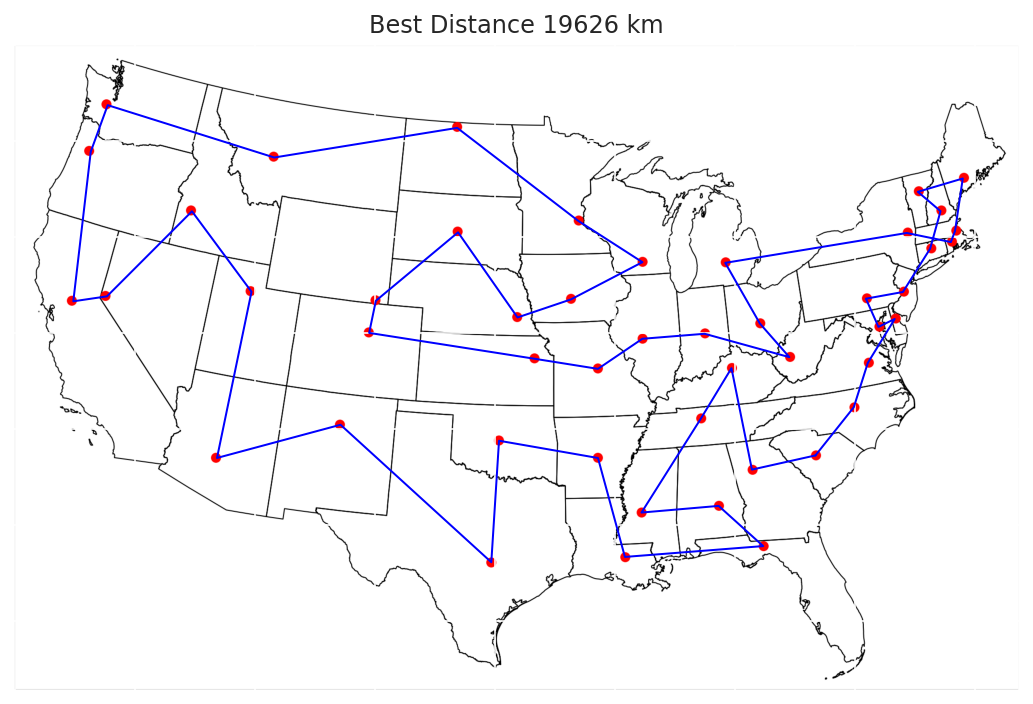

In [45]:
## previous version - this is the version that's in the video
## there aren't substantive changes, mostly we refactored the old code
## and rewrote a couple of bits to use the distance matrix instead of
## the coordinates

# define move, objective, and local search functions

def sub_tour_reversal(tour, i, j):
    # reverse the segment from i to j
    if i > j: # swap if i not less than j
        i, j = j, i
    n = len(tour)
    return (np.concatenate((tour[0:i], tour[j:-n + i - 1:-1],tour[j + 1:n])))

def tour_distance(tour, xy):
    # return tour distance in kilometers
    xy_tmp = xy[tour,:]
    return (np.sum(
        np.sqrt(
            np.sum(np.diff(xy_tmp, axis=0, append=[xy_tmp[0,:]])**2, axis=1)))
            / 1000)


def random_reversal_search(xy, max_no_improve):
    num_cities = xy.shape[0]
    # starts from a random tour
    current_tour = np.random.permutation(np.arange(num_cities))
    current_dist = tour_distance(current_tour, xy) 

    # stop search if no better tour is found within max_no_improve iterations, can increase to eliminate crossovers
    num_moves_no_improve = 0
    iterations = 0
    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        iterations += 1  # just for tracking
        i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
        new_tour = sub_tour_reversal(current_tour, i, j)
        new_dist = tour_distance(new_tour, xy)
        if new_dist < current_dist:
            num_moves_no_improve = 0
            current_tour = new_tour # accept the move if it's an improvement
            current_dist = new_dist
    return current_tour, current_dist, iterations

best_tour, best_dist, iterations = random_reversal_search(xy, 200)
print(f"The minimum distance found is {best_dist:.0f} after {iterations:d} iterations")
plot_tour(best_tour, xy, best_dist, 9, 6)